# Cat vs. Dog vs. Fox: Transfer Learning in PyTorch

## Objective
Apply transfer learning techniques to fine-tune a pre-trained model in PyTorch for a multi-class classification task: distinguishing between images of cats, dogs, and foxes. This project develops skills in dataset preparation, model fine-tuning, and performance evaluation.
## Problem Description
Cats, dogs, and foxes are often confused due to their physical similarities, such as fur patterns, ear shapes, and size. This project aims to create a machine learning model that classifies images into one of three categories:

* Cat
* Dog
* Fox

Using transfer learning, this project leverages the pre-trained ResNet model from PyTorch to develop an effective classification system.

## Requirements

### Data Preparation:
1. Use or create a dataset with labeled images of cats, dogs, and foxes. Suggested sources include public image datasets such as those on Kaggle.
2. Split the dataset into training, validation, and test sets.
3. Preprocess the images to meet the input requirements of your chosen pre-trained model (e.g., resizing, normalization).

For my dataset I found an animal classification dataset from Kaggle at: https://www.kaggle.com/datasets/anthonytherrien/image-classification-64-classes-animal.

In [23]:
# %pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anthonytherrien/image-classification-64-classes-animal")

print("Path to dataset files:", path)

Note: you may need to restart the kernel to use updated packages.


100%|██████████████████████████████████████| 5.71G/5.71G [02:46<00:00, 36.9MB/s]

Extracting files...


Path to dataset files: /Users/michael.murray.iv/.cache/kagglehub/datasets/anthonytherrien/image-classification-64-classes-animal/versions/1


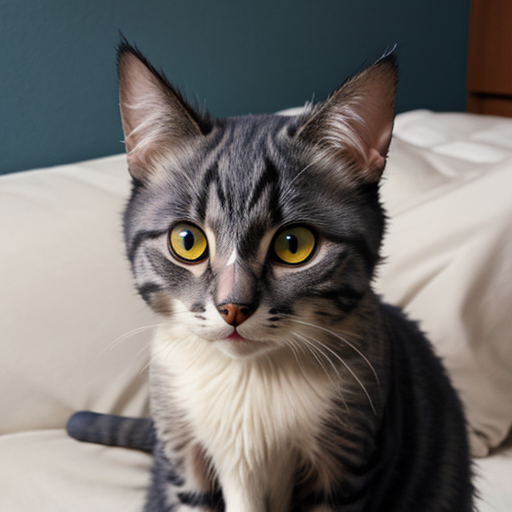

In [49]:
import os
from IPython.display import Image
Image('path/to/your/image.png')
# Assuming image files are in a subdirectory named 'images'
cat_dir = path + "/image/cat"
dog_dir = path + "/image/dog"
fox_dir = path + "/image/fox"

cats = os.listdir(cat_dir)
dogs = os.listdir(dog_dir)
foxes = os.listdir(fox_dir)

# print sample image
cat = cat_dir + "/" + cats[0]
Image(cat)


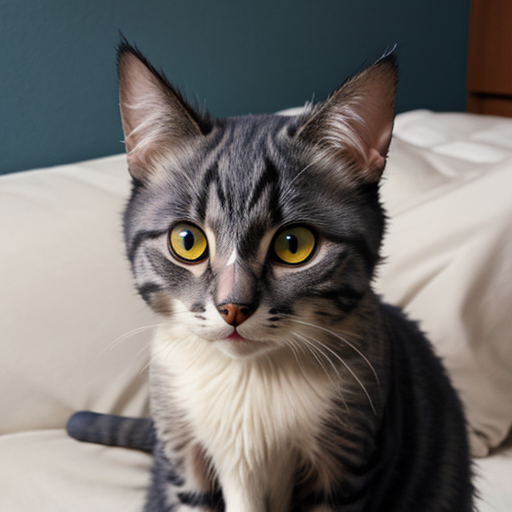

In [52]:
# have model train on same number of input images for each animal type
min_animal_len = min(len(cats), len(dogs), len(foxes))
cats = cats[:min_animal_len]
dogs = dogs[:min_animal_len]
foxes = foxes[:min_animal_len]

dataset = []
for i in range(min_animal_len):
    dataset.append([cat_dir + "/" + cats[i], "cat"])
    dataset.append([dog_dir + "/" + dogs[i], "dog"])
    dataset.append([fox_dir + "/" + foxes[i], "fox"])

c,d,f = dataset[0][0], dataset[1][0], dataset[2][0]
Image(c)
# Image(d)
# Image(f)

In [59]:
# split dataset into training and test sets
p_train = 0.7 # 70/30 train/test
training_size = int(len(dataset)*.7)
training_data = dataset[:training_size]
testing_data = dataset[training_size:]
print("Actual split =", len(training_data)/len(dataset))

Actual split = 0.6990740740740741


### Model Selection and Fine-Tuning:
1. Choose a pre-trained model from PyTorch’s torchvision.models library (e.g., ResNet, VGG, or EfficientNet).
2. Replace the model’s classification head with a custom fully connected layer for three output classes (cat, dog, fox).
3. Fine-tune the model on your dataset, optimizing the training process to achieve the best results.

### Evaluation:
1. Assess the model’s performance using metrics such as accuracy, precision, recall, and F1-score.
2. Visualize the confusion matrix to identify common misclassifications.

### Explainability (Optional):
Use tools like Grad-CAM to visualize what parts of the image the model focuses on for each class.
Discuss whether the model’s learned features align with human intuition (e.g., ear shape, snout length).

## Commit and Push changes to GitHub

In [19]:
commit_message = input("Enter your commit message: ")
!git add Transfer\ Learning.ipynb
!git commit -m "{commit_message}"
!git push origin main

Enter your commit message:  updated formatting


[main 4b790c1] updated formatting
 1 file changed, 20 insertions(+), 49 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 8 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 681 bytes | 681.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/michaelmurrayiv/Transfer-Learning.git
   4e33cbc..4b790c1  main -> main
